# Zonal mean for Southern Hemisphere

In [1]:
# OS関連 (OS-related)
import os
# 数値計算とデータ分析 (Numerical computation and data analysis)
import numpy as np
import pandas as pd
# 可視化 (Visualization)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as mticker
#from mpl_toolkits.basemap import Basemap, addcyclic
# 科学計算 (Scientific computing)
from scipy import signal
import math
# 地図描画 (Map plotting)
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
# 日付と時間 (Date and time)
from datetime import datetime, timedelta
# 多次元データ操作 (Multi-dimensional data manipulation)
import xarray as xr
# netCDF操作 (netCDF operations)
import netCDF4 as nc
# オブジェクトコピー (Object copying)
from copy import copy
# カスタムモジュール (Custom modules)
from read_gtool import read_gtool
from command import command as cmd
from DateInformation import DateInformation
from CheckModelVariable import VariableProcessor as CheckModelVariable

In [2]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False})

# 解析する時間ステップ
time_step = "M"
#time_step = "D"

# 日付情報の取得
date_info = DateInformation(start_year=1981, end_year=2010, 
                            time_step=time_step, consider_leap_year=True)

## データの読み込み

# 解析する季節
#seas0 = "Aug"
#seas0 = "Jul"
#seas0 = "JJA"
seas0 = "ann"

# 解析する変数
variables=[ "T2","prcp","v850", "vprecwtot","prcp_d18O","sens","evap","precwtot","precw_d18O","u250",
 #          "vv850zonaleddy_highpass8days", "qtv850zonaleddy_highpass8days","tv850zonaleddy_highpass8days",
          "gricr","grsst"]
cmap_levels = {
    "u": [-60, 60, 5],
    "v": [-20, 20, 1],
    "z": [-200, 200, 20],
}
var_units= {
    "u": "m/s",
    "v": "m/s",
    "z": "m",
}

# 解析する領域
#area = [0, 360, -90, -40]
area = [-180, 180, -90, -40]
#area = [-20, 160, -90, -40] # 東南極のみ。西南極を含めてしまうと、そちらの変動が大きくてひっぱられてしまう。
#area = [0, 180, -90, -40]
#area = [0, 360, -90,  90]
#area = [0, 60,   30, 130]

west, east, south, north = area
area_sufix=f"{west}-{east}_{south}-{north}"

# Check
print(f"Composite analysis for {time_step}  {seas0}.")
print(f"masking area: lon={west}-{east}°, lat={south}-{north}°")
yrst=1981
yred=2010

Composite analysis for M  ann.
masking area: lon=-180-180°, lat=-90--40°


In [3]:
for variable in variables:
    processor = CheckModelVariable(variable, time_step=time_step)
    processor.process()

experiments = {
     "PI": "PI.AMIP_t42.20230831",
     "LGM_Mw/Gice": "LGM.miroc_glomapice_anomtopo_t42.20230831",
     "LGM_M": "LGM.miroc_anomtopo_t42.20230831",
     "LGM_G": "LGM.glomap_anomtopo_t42.20230831",
 }


# Define colors for each experiment

colors = {
    'PI': 'black',
    'LGM_G': 'red',
    'LGM_M': 'blue',
    'LGM_Mw/Gice': 'green',
 'LGM_T':"purple",
    'Nudged': 'gray',
}

# Experiments
gt = read_gtool()
gt.dim="xyt"
gt.cyclic = True

# Read all data
datasets = {}
units = {}
title ={}
for label, experiment in experiments.items():
    data_dir = f"{processor.current_directory}/model_outputs/{experiment}"
    for variable in variables:
        gt.var = f'{data_dir}/clm/{variable}'
        key = f'{variable}-{label}'
        units[variable]=gt.get_gtool_varunit()

        if not os.path.exists(gt.var):
            print(f"Error! {variable} not existed!")
            exit()

        datasets[key] = gt.gtopen()
        if ("vprecw" in key):
            print(1,key)
            datasets[key] = datasets[key]*-1 # southward positive
        if ("prcp" in key) & ("d18O" not in key):
            datasets[key] = datasets[key]*2500*1000 # kg/m2/s -> W/m2
        if ("QV" in key) or ("qt" in key) or ("Q01V" in key):
            datasets[key] = datasets[key]*1000 # kg/kg -> g/kg
        if variable in ["gricr","relh_s"]:
            print(key)
            datasets[key] = datasets[key]*100 # fraction -> %

        if "eddy" in key and not "vv" in key:
            datasets[key] = datasets[key]*-1 # inverse (southward positive)
            print(key)
                
        if ("grsst" in key) or ("T2" in key):
            # 軸情報の読み込み
            dlon, dlat, dlev = gt.get_gtool_xyzaxis() # get axes 
            datasets[key] = datasets[key] - 273.15
            if "grsst" in key:
                newkey = f'sstgrad-{label}'
                print(newkey)
                ddlat= dlat[:-1]-dlat[1:]
    #            datasets[newkey] = np.gradient(datasets[key], axis=2)
                datasets[newkey] = np.empty(np.shape(datasets[key]))
                datasets[newkey][:,1:,:] = datasets[key][:,:-1,:]-datasets[key][:,1:,:]
                datasets[newkey][:,0,:] = 0

                nt, ny, nx = np.shape(datasets[key])

                for tt in range(nt):
                    for ii in range(nx):
                        datasets[newkey][tt,1:,ii] = datasets[newkey][tt,1:,ii]/ddlat
    datasets[f'vflow-{label}']=datasets[f'vprecwtot-{label}']/datasets[f'precwtot-{label}']                    
#    datasets[f"QV850mean-{label}"] = datasets[f"qt850-{label}"]*datasets[f"v850-{label}"]

#units["prcp"] = "$\mathrm{W/m^2}$"
units["prcp"] = "%"
title["prcp"] = "Precipitation"
units["evap"] = "$\mathrm{W/m^2}$"
title["evap"] = "Evaporation"
units["sens"] = "$\mathrm{W/m^2}$"
title["sens"] = "Sensible heat"
units["gricr"] = "%"
title["gricr"]="Sea ice concentration (SIC)"
units["grsst"] = "℃"
title["grsst"] = "Sea surface temperature (SST)"
units["T2"] = "℃"
title["T2"] = "Surface air temperature ($T_a$)"
title["relh_s"] = "Relative humidity"
units["relh_s"] = "%"
units["QV850"] = "g/kg m/s"
units["TV850"] = "℃ m/s"
units["qt850"] = "g/kg"
units["qt850turb"] = units["qt850"]
units["QV850turb"] = units["QV850"]
units["TV850turb"] = units["TV850"]

units["TV850zonaleddy"] = units["TV850"]
units["qt850zonalmean"] = units["qt850"]
units["QV850zonalmean"] = units["QV850"]
units["TV850zonalmean"] = units["TV850"]
units["vv850zonaleddy_highpass8days"] = "$\mathrm{(m/s)^2}}$"
title["vv850zonaleddy_highpass8days"] = "Southward eddy momentumn flux ($\overline{ V^{\prime 2}}$) @850 hPa"
#units["qtv850zonaleddy_highpass8day"] = "g/kg m/s$"
units["qtv850zonaleddy_highpass8days"] = "g/kg m/s"
title["qtv850zonaleddy_highpass8days"] = "Eddy moisture flux ($\overline{Q^\prime V^\prime}$) @850 hPa"
units["tv850zonaleddy_highpass8days"] = "K m/s"
title["tv850zonaleddy_highpass8days"] = "Eddy heat flux ($\overline{T^\prime V^\prime}$) @850 hPa"
title["u850"]= "Zonal wind @850 hPa"
units["u850"]= "m/s"
title["u250"]= "Zonal wind @250 hPa"
units["u250"]= "m/s"
title["v850"]= "Meridional wind @850 hPa"
units["v850"]= "m/s"

units["prcp_d18O"]= "‰"
units["precw_d18O"]= "‰"
title["prcp_d18O"]= "$\mathrm{\delta^{18}O}$ of precipitation ($\mathrm{\delta^{18}O_{p}}$)"
title["precw_d18O"]= "$\mathrm{\delta^{18}O}$ of precipitable water ($\mathrm{\delta^{18}O_{prw}}$)"
units["sstgrad"] = "℃/°"
title["sstgrad"] = "Meridional SST gradient"
units["precwtot"] = "%"
title["precwtot"] = "Precipitable water"
units["vprecwtot"] = "kg/m/s"
title["vprecwtot"] = "Total meridional moisture flux"
units["vflow"] = "m/s"
title["vflow"] = "Moisture weighted meridional wind"

title['vprecw_1y_lp'] = "Mean meridional moisture flux ($Q_m$)"
title['vprecw_10d_lp']= "LF meridional moisture flux ($Q_{LF}$)"
title['vprecw_10d_lp_residual']="Synoptic meridional moisture flux ($Q_{syn}$)"
units['vprecw_1y_lp'] = "kg/m/s"
# units['vprecw_10d_lp']= "kg/m/s"
# units['vprecw_10d_lp_residual']= "kg/m/s"
#units['vprecw_1y_lp'] = "%"
units['vprecw_10d_lp']= "%"
units['vprecw_10d_lp_residual']= "%"

variables_filtered=['vprecw_10d_lp_residual','vprecw_10d_lp','vprecw_1y_lp']

variables.append(f'sstgrad')
variables.append(f'vflow')

# 軸情報の読み込み
gtax = read_gtool()
gtax.dim="xy"
gtax.var=f"{data_dir}/clm/T2"
dlon, dlat, dlev = gtax.get_gtool_xyzaxis() # get axes 
# 軸の長さ
nlat, nlon = len(dlat),len(dlon)

mask_lat = dlat<-65

for variable in datasets.keys():

    if (str(850) in variable) or ("gricr" in variable) or ("grsst" in variable) or ("sstgrad" in variable):
        datasets[variable][:,mask_lat,:] = np.nan

filter_types=["1y_lp","10d_lp","10d_lp_residual"]
for label, experiment in experiments.items():
    data_dir = f"{processor.current_directory}/model_outputs/{experiment}"
    for filter in filter_types:
        for variable in ["vprecw"]:
#        variable="vprecw"
            key = f'{variable}_{filter}-{label}'
    #        filename=f"{data_dir}/clm/ann/uvqt_{filter}.npz"
            if filter == "1y_lp":
                filename=f"{data_dir}/clm/ann/uvqt_clm.npz"
            elif filter == "10d_lp":
                filename=f"{data_dir}/clm/ann/uvqt_10d_lp_clmanom.npz"
            else:
                filename=f"{data_dir}/clm/ann/uvqt_10d_lp_clmanom_residual.npz"
            try:
                npz_data= np.load(filename)
                datasets[key] = npz_data[variable].T
            except:
                print(f"No file! {filename}")
            if f'{variable}_{filter}' not in variables:
                variables.append(f'{variable}_{filter}')
            

def set_pn(x,y,ratio):
    return abs(ratio)*np.where(x >= y, 1, -1)

# Calculate averages
annual_datasets={}
annual_zonal_datasets={}
annual_zonalanom_datasets={}
annual_zonal_datasets_E={}
annual_zonalanom_datasets_E={}
annual_zonal_datasets_W={}
annual_zonalanom_datasets_W={}

zonmean_index=int(len(dlon)-1)
#zonmean_index=len(dlon)
#zonmean_index=int(len(dlon)/2)
for variable in variables:
    if not "Q_d18O" in variable:
        for label, experiment in experiments.items():
            key = f"{variable}-{label}"
            if key in datasets.keys():
                if variable in variables_filtered:
                    annual_datasets[key] = datasets[key]*-1
                    annual_zonal_datasets[key] = np.nanmean(annual_datasets[key][...,:zonmean_index], axis=1)
                    annual_zonal_datasets_E[key] = np.nanmean(annual_datasets[key][...,:int(zonmean_index/2)], axis=1)
                    annual_zonal_datasets_W[key] = np.nanmean(annual_datasets[key][...,int(zonmean_index/2):], axis=1)
                else:
                    if "d18O" in variable:
                        if "prcp" in variable:
                            weight_var="prcp"
                        elif "precw" in variable:
                            weight_var = "precwtot"
                        else:
                            print("Undefined isotope!")
                        annual_datasets[key]= np.nanmean(datasets[key]*datasets[f"{weight_var}-{label}"], axis=0)/np.nanmean(datasets[f"{weight_var}-{label}"], axis=0)
                        annual_zonal_datasets[key]= np.nanmean(annual_datasets[key][...,:zonmean_index]*annual_datasets[f"{weight_var}-{label}"][...,:zonmean_index], axis=1)/np.nanmean(annual_datasets[f"{weight_var}-{label}"][...,:zonmean_index], axis=1)
                        annual_zonal_datasets_E[key]= np.nanmean(annual_datasets[key][...,:int(zonmean_index/2)]*annual_datasets[f"{weight_var}-{label}"][...,:int(zonmean_index/2)], axis=1)/np.nanmean(annual_datasets[f"{weight_var}-{label}"][...,:int(zonmean_index/2)], axis=1)
                        annual_zonal_datasets_W[key]= np.nanmean(annual_datasets[key][...,int(zonmean_index/2):]*annual_datasets[f"{weight_var}-{label}"][...,int(zonmean_index/2):], axis=1)/np.nanmean(annual_datasets[f"{weight_var}-{label}"][...,int(zonmean_index/2):], axis=1)
                    else:
                        annual_datasets[key]= np.nanmean(datasets[key], axis=0)
                        annual_zonal_datasets[key]= np.nanmean(annual_datasets[key][...,:zonmean_index], axis=1)
                        annual_zonal_datasets_E[key]= np.nanmean(annual_datasets[key][...,:int(zonmean_index/2)], axis=1)
                        annual_zonal_datasets_W[key]= np.nanmean(annual_datasets[key][...,int(zonmean_index/2):], axis=1)
    
            else:
                print(f"Not existed in datasets: {key}")
    #    if "qt" in variable:
        if variable in ["qt850","precw","qt_s","precwtot","prcp",'vprecw_10d_lp_residual','vprecw_10d_lp']:
#        if variable in ["qt850","precw","qt_s","precwtot","prcp",'vprecw_10d_lp_residual','vprecw_10d_lp',"vprecwtot"]:
            annual_zonalanom_datasets[f"{variable}-SSTeffect"]= (annual_zonal_datasets[f"{variable}-LGM_G"] / annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"]-1)*100
            annual_zonalanom_datasets_E[f"{variable}-SSTeffect"]= (annual_zonal_datasets_E[f"{variable}-LGM_G"] / annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"]-1)*100
            annual_zonalanom_datasets_W[f"{variable}-SSTeffect"]= (annual_zonal_datasets_W[f"{variable}-LGM_G"] / annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"]-1)*100
            annual_zonalanom_datasets[f"{variable}-SIeffect"]= (annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"] /annual_zonal_datasets[f"{variable}-LGM_M"]-1)*100
            annual_zonalanom_datasets_E[f"{variable}-SIeffect"]= (annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"] /annual_zonal_datasets_E[f"{variable}-LGM_M"]-1)*100
            annual_zonalanom_datasets_W[f"{variable}-SIeffect"]= (annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"] /annual_zonal_datasets_W[f"{variable}-LGM_M"]-1)*100
            if variable in ["vprecwtot",*variables_filtered]:
                annual_zonalanom_datasets[f"{variable}-SSTeffect"]= set_pn(annual_zonal_datasets[f"{variable}-LGM_G"],annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"],annual_zonalanom_datasets[f"{variable}-SSTeffect"])
                annual_zonalanom_datasets_E[f"{variable}-SSTeffect"]=set_pn(annual_zonal_datasets_E[f"{variable}-LGM_G"],annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"],annual_zonalanom_datasets_E[f"{variable}-SSTeffect"])
                annual_zonalanom_datasets_W[f"{variable}-SSTeffect"]=set_pn(annual_zonal_datasets_W[f"{variable}-LGM_G"],annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"],annual_zonalanom_datasets_W[f"{variable}-SSTeffect"])
                annual_zonalanom_datasets[f"{variable}-SIeffect"]= set_pn(annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"],annual_zonal_datasets[f"{variable}-LGM_M"],annual_zonalanom_datasets[f"{variable}-SIeffect"])
                annual_zonalanom_datasets_E[f"{variable}-SIeffect"]=set_pn(annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"],annual_zonal_datasets_E[f"{variable}-LGM_M"],annual_zonalanom_datasets_E[f"{variable}-SIeffect"])
                annual_zonalanom_datasets_W[f"{variable}-SIeffect"]= set_pn(annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"],annual_zonal_datasets_W[f"{variable}-LGM_M"],annual_zonalanom_datasets_W[f"{variable}-SIeffect"])
            if variable == 'vprecw_1y_lp':# to avoid 0-div
                annual_zonalanom_datasets[f"{variable}-SSTeffect"][annual_zonalanom_datasets[f"{variable}-SSTeffect"]<-2000]=np.nan 
                annual_zonalanom_datasets_E[f"{variable}-SSTeffect"][annual_zonalanom_datasets_E[f"{variable}-SSTeffect"]<-2000]=np.nan
                annual_zonalanom_datasets_W[f"{variable}-SSTeffect"][annual_zonalanom_datasets_W[f"{variable}-SSTeffect"]<-2000]=np.nan
                annual_zonalanom_datasets[f"{variable}-SIeffect"][annual_zonalanom_datasets[f"{variable}-SIeffect"]<-2000]=np.nan 
                annual_zonalanom_datasets_E[f"{variable}-SIeffect"][annual_zonalanom_datasets_E[f"{variable}-SIeffect"]<-2000]=np.nan
                annual_zonalanom_datasets_W[f"{variable}-SIeffect"][annual_zonalanom_datasets_W[f"{variable}-SIeffect"]<-2000]=np.nan

        else:
            annual_zonalanom_datasets[f"{variable}-SSTeffect"]= annual_zonal_datasets[f"{variable}-LGM_G"] - annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"]
            annual_zonalanom_datasets_E[f"{variable}-SSTeffect"]= annual_zonal_datasets_E[f"{variable}-LGM_G"] - annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"]
            annual_zonalanom_datasets_W[f"{variable}-SSTeffect"]= annual_zonal_datasets_W[f"{variable}-LGM_G"] - annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"]
            annual_zonalanom_datasets[f"{variable}-SIeffect"]= annual_zonal_datasets[f"{variable}-LGM_Mw/Gice"] - annual_zonal_datasets[f"{variable}-LGM_M"]
            annual_zonalanom_datasets_E[f"{variable}-SIeffect"]= annual_zonal_datasets_E[f"{variable}-LGM_Mw/Gice"] - annual_zonal_datasets_E[f"{variable}-LGM_M"]
            annual_zonalanom_datasets_W[f"{variable}-SIeffect"]= annual_zonal_datasets_W[f"{variable}-LGM_Mw/Gice"] - annual_zonal_datasets_W[f"{variable}-LGM_M"]
            
#            annual_zonalanom_datasets[f"{variable}-LGManom_GT"]= annual_zonal_datasets[f"{variable}-LGM_G"] - annual_zonal_datasets[f"{variable}-LGM_T"]


## 描画

# Define a function to format the tick labels
def format_latitude(x, pos):
    if x < 0:
        return f"{abs(int(x))}°S"
    elif x > 0:
        return f"{abs(int(x))}°N"
    else:
        return "0°"

1 vprecwtot-PI
gricr-PI
sstgrad-PI
1 vprecwtot-LGM_Mw/Gice
gricr-LGM_Mw/Gice
sstgrad-LGM_Mw/Gice
1 vprecwtot-LGM_M
gricr-LGM_M
sstgrad-LGM_M
1 vprecwtot-LGM_G
gricr-LGM_G
sstgrad-LGM_G


In [4]:
sub_num=[]
sub_num2=[]
for i in range(97, 123):
    sub_num.append(chr(i))

for i in range(107, 123):
    sub_num2.append(chr(i))
#Change this to match your latitude values
idx = np.where((dlat >= -85) & (dlat <= -60))

#for seas in ["annual", "DJF", "JJA"]:
seas="annual"
if seas =="annual":
    dataset = annual_zonal_datasets
elif seas == "DJF":
    dataset = DJF_zonal_datasets
else:
    dataset= JJA_zonal_datasets

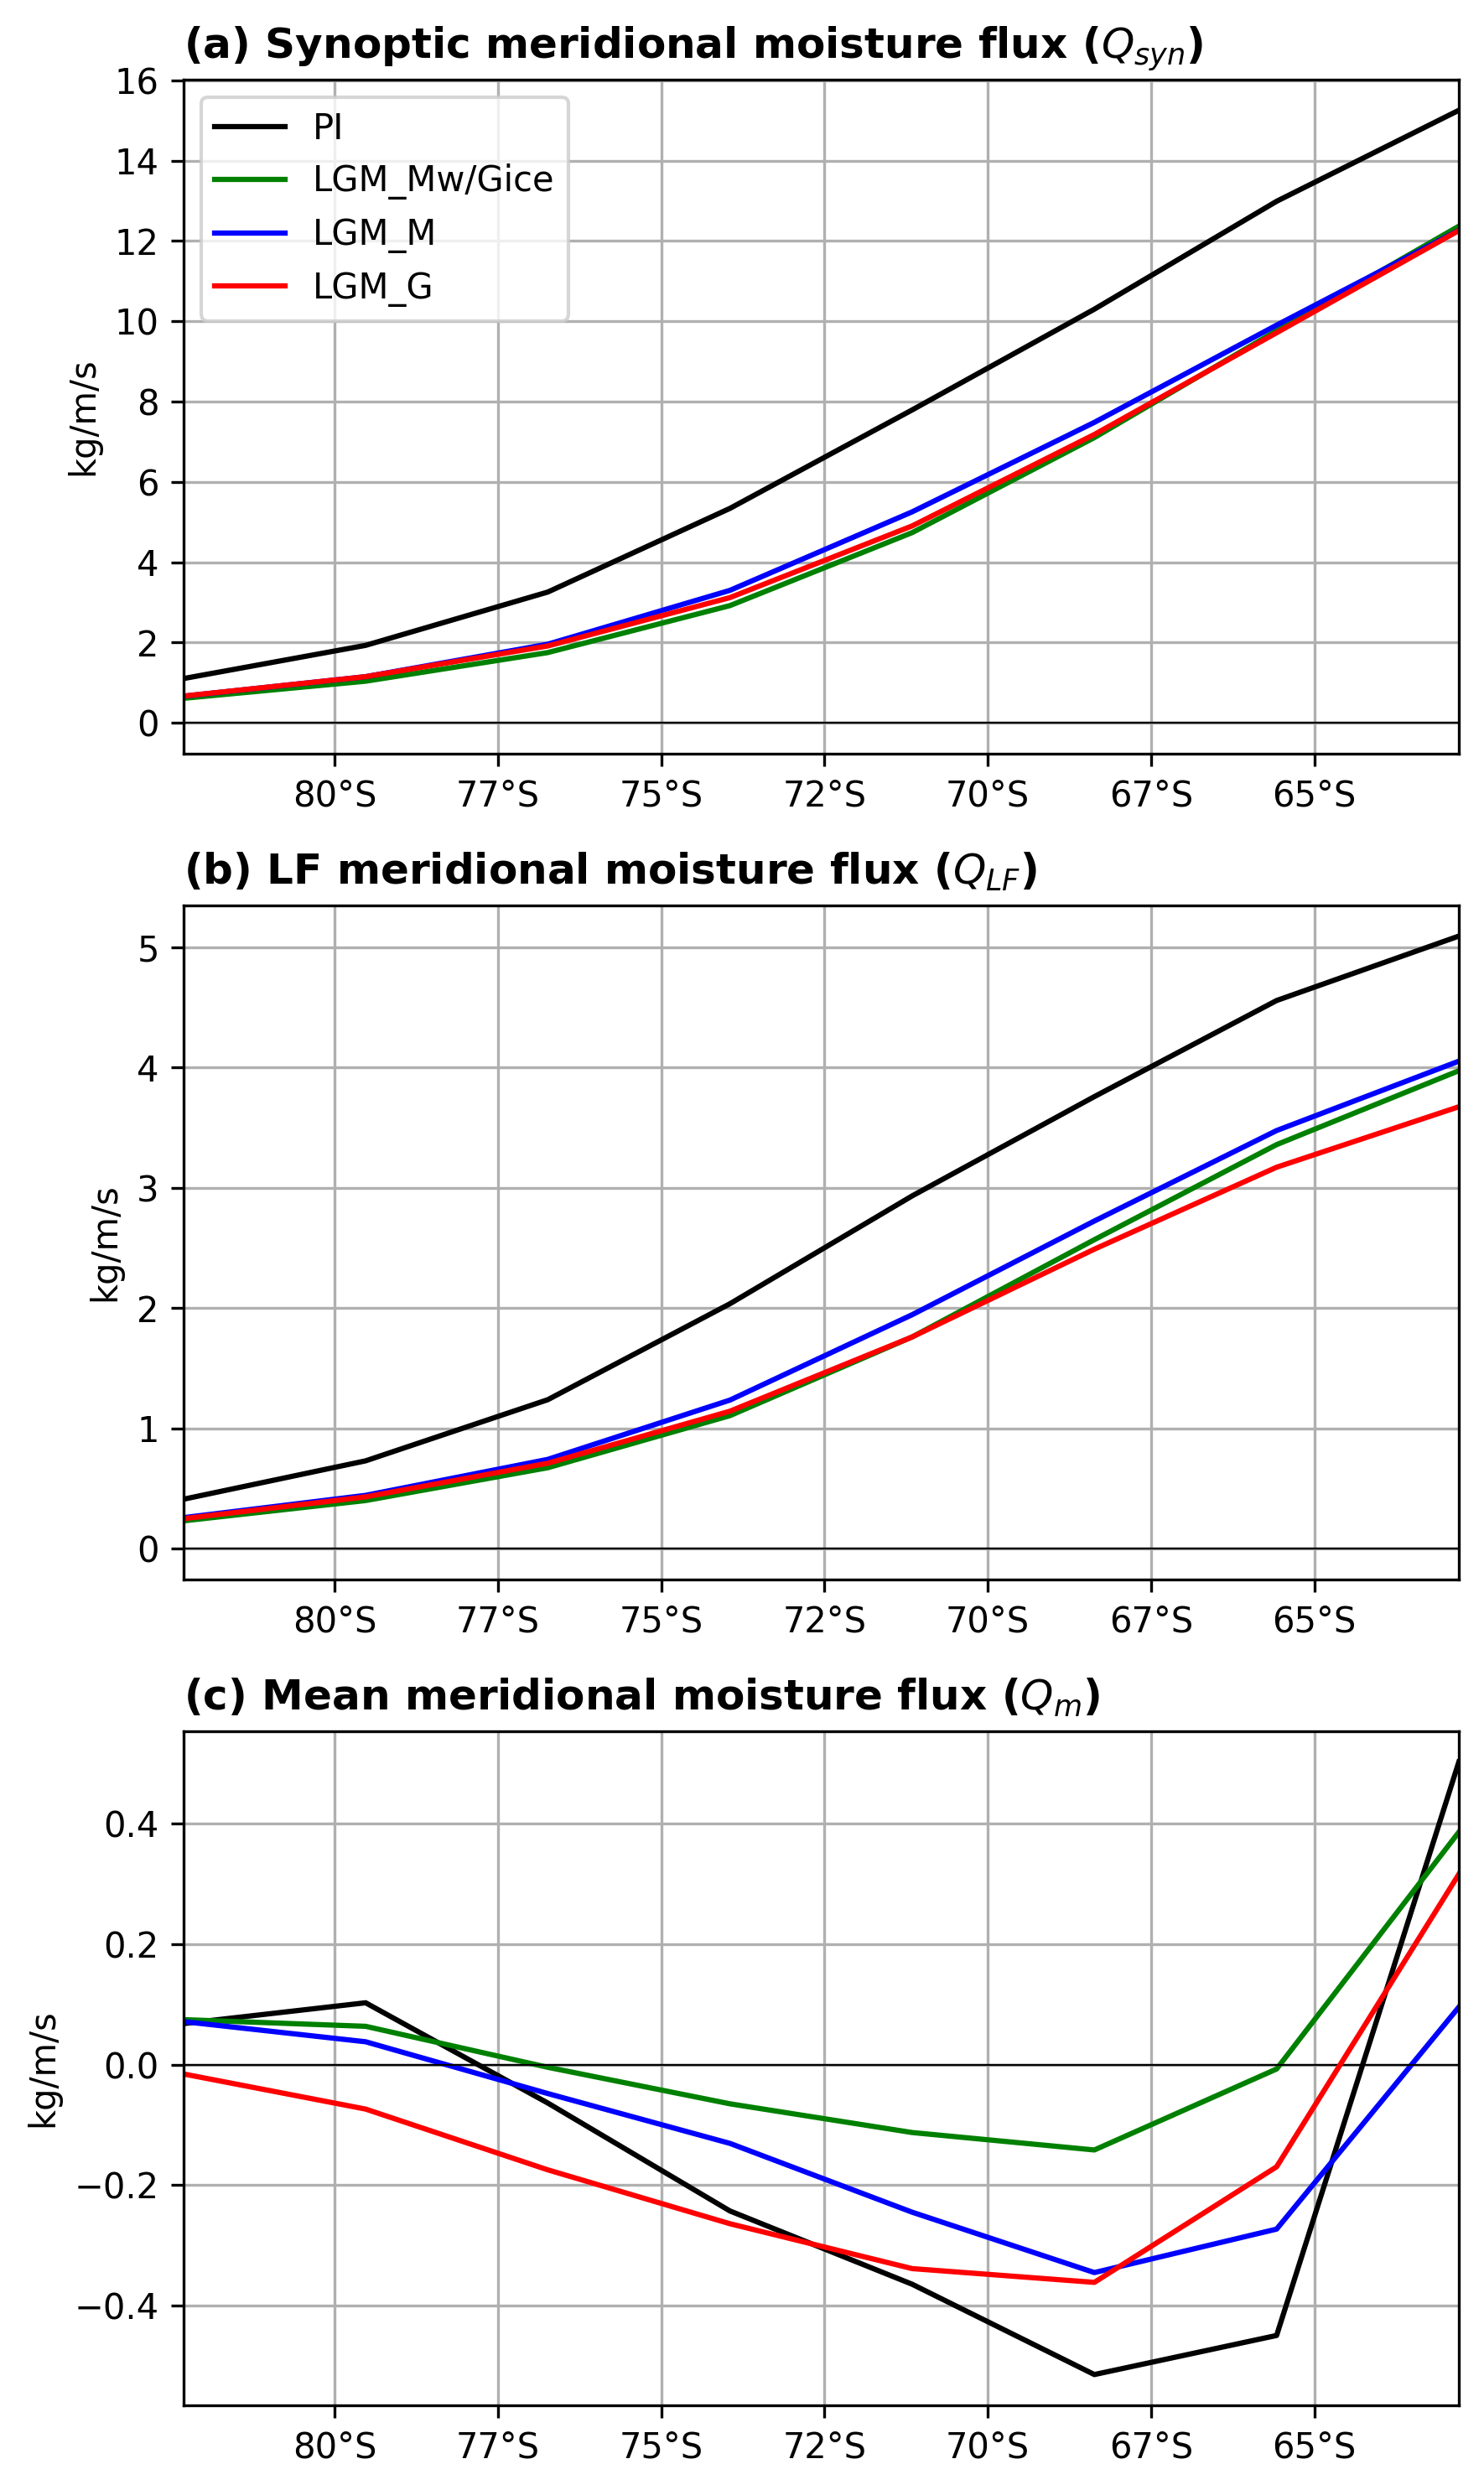

In [5]:
fig, ax = plt.subplots(figsize=(6, 10))
plot_legend=True
for i, variable in enumerate(variables_filtered, start=1):
    data_for_variable = {label: data for label, data in dataset.items() if label.startswith(f"{variable}-")}
    # Create subplot for this variable
    ax = plt.subplot(math.ceil(len(variables_filtered)), 1, i)

    for label, data in data_for_variable.items():

        expname=label.split('-')[1]

        color = colors.get(expname, 'gray')  # Get color from dictionary, default to black if not found
#        linestyle = '-' if 'glomap' in label else '--'  # Solid line for GLOMAP, dashed for others
        linestyle ="-"

        ax.axhline(y=0,c="k",linewidth=0.5,zorder=2)
        ax.plot(dlat[idx], data[idx], label=expname, 
                linestyle=linestyle, color=color)
    # if "vprecw" in label:
    #     ax.set_ylim(-0,5)
#    ax.set_ylabel(rf"{units[variable]}")
    ax.set_ylabel(rf"kg/m/s")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_latitude))
    ax.grid(True,zorder=1)


    ax.set_title(rf"({sub_num[i-1]}) {title[variable]}", loc="left",weight="demibold")#, {seas}")
#    ax.set_title(rf"{title[variable]}", loc="left",weight="demibold")#, {seas}")
    ax.set_xlim(dlat[idx][-1],dlat[idx][0])

    if "V" in variable:
#        ax = plt.gca()
        ax.invert_yaxis
        
    if plot_legend:
        ax.legend(fontsize=10)
        plot_legend = False

plt.tight_layout()    
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math

In [7]:
idx = np.where((dlat >= -85) & (dlat <= -60))

seas = "annual"  # 例として "annual" を使用
if seas == "annual":
    dataset = annual_zonal_datasets
elif seas == "DJF":
    dataset = DJF_zonal_datasets
else:
    dataset = JJA_zonal_datasets

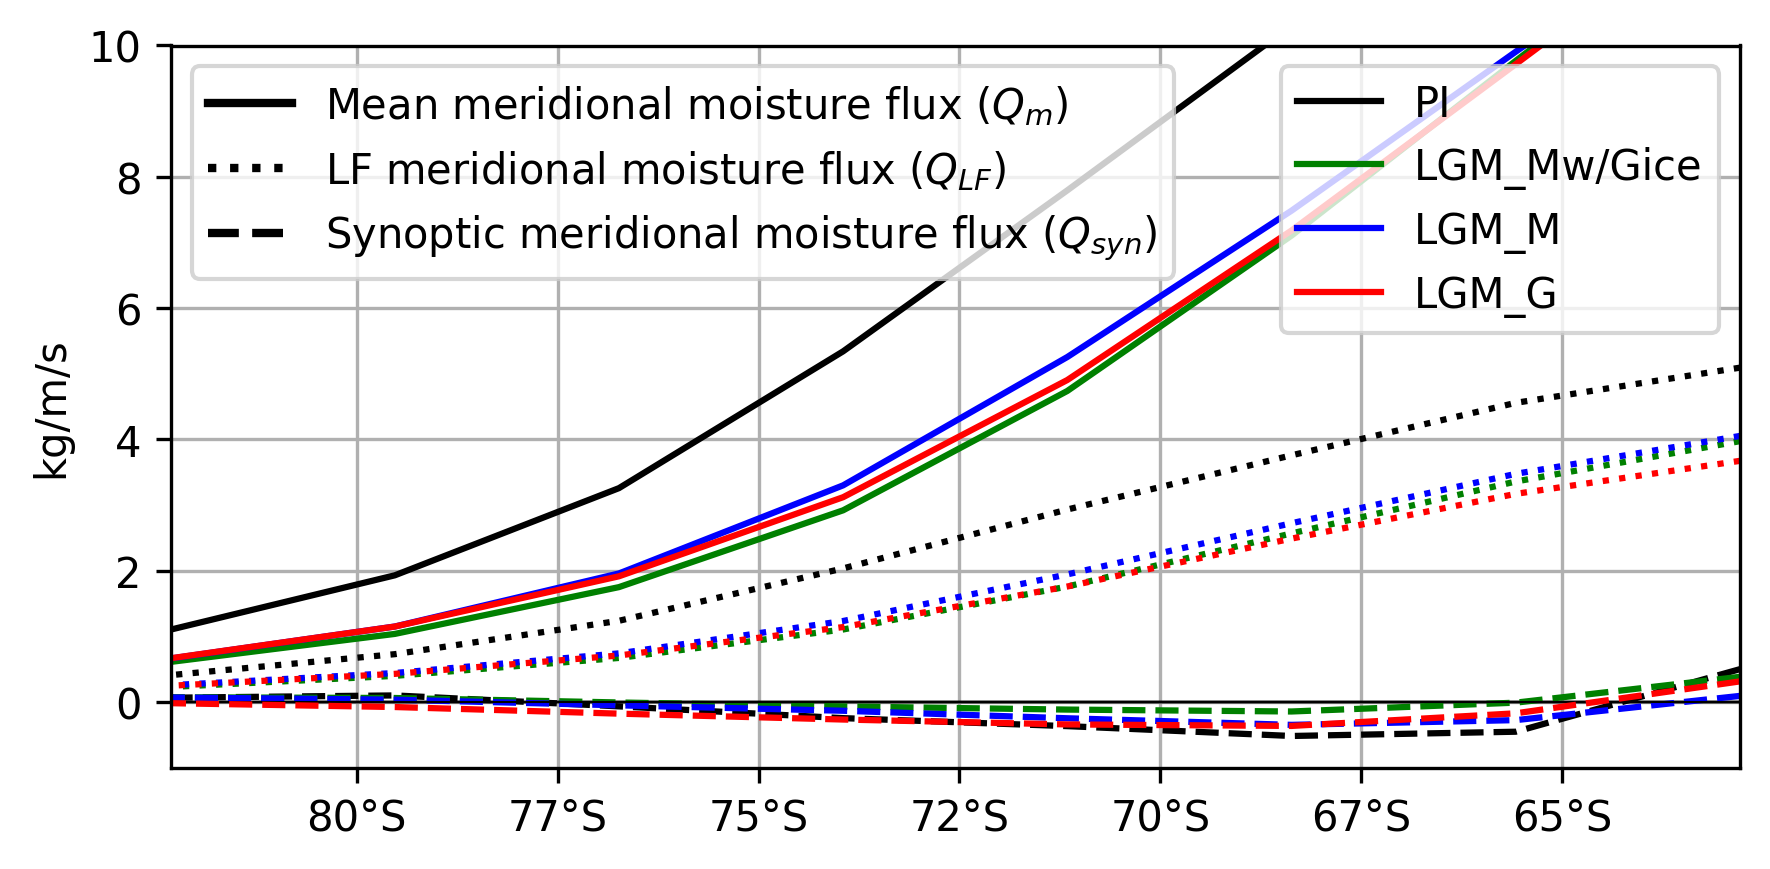

In [8]:
fig, ax = plt.subplots(figsize=(6,3))
linestyle = ["solid", "dotted","dashed"]
line_labels = [title['vprecw_1y_lp'],title['vprecw_10d_lp'],title['vprecw_10d_lp_residual']]

# 最初の凡例用
first_legend_labels = []
i = 0  # 線種のインデックス用変数
plot_legend=True
for variable in variables_filtered:
    data_for_variable = {label: data for label, data in dataset.items() if label.startswith(f"{variable}-")}
    
    for label, data in data_for_variable.items():
        expname = label.split('-')[1]
        color = colors.get(expname, 'gray')

        ax.axhline(y=0, c="k", linewidth=0.5, zorder=2)
        if plot_legend:
            label = expname
        else:
            label = ""
        plot, = ax.plot(dlat[idx], data[idx], label=label, linestyle=linestyle[i % len(linestyle)], color=color)

        

        if expname not in first_legend_labels:
            first_legend_labels.append(expname)

    ax.set_ylabel(rf"{units[variable]}")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_latitude))
    ax.grid(True, zorder=1)
    ax.set_xlim(dlat[idx][-1], dlat[idx][0])
    ax.set_ylim(-1,10)

    if "V" in variable:
        ax.invert_yaxis
    if plot_legend:
        ax.legend(fontsize=10)
        plot_legend = False
        
    i += 1  # 次の線種へ移動
    
# 最初の凡例（色に関する凡例）
first_legend = ax.legend(fontsize=10, loc="upper right")
plt.gca().add_artist(first_legend)

# 2番目の凡例（線種類に関する凡例）
lines = [plt.Line2D([0], [0], color='black', linewidth=2, linestyle=ls) for ls in linestyle]
second_legend = ax.legend(lines, line_labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
def draw_zonalmean(variables_to_draw,sub_num=sub_num):
    # Get appropriate latitude range index
    idx = np.where((dlat >= -85) & (dlat <= -20))
    
    # Create figure
    fig = plt.figure(figsize=(15, 4))
    plot_legend = False
    
    # Loop through variables to draw
    for i, variable in enumerate(variables_to_draw, start=1):
        ax = plt.subplot(math.ceil(len(variables_to_draw) / 4), 4, i)
        data_for_variable = {label: data for label, data in annual_zonalanom_datasets.items() if label.startswith(f"{variable}-")}
        
        for label, data in data_for_variable.items():
            expname = label.split('-')[1]
            color = colors.get(expname, 'gray')
            linestyle = "-"
            unit = rf"[{units[variable]}]"
            ylim = None
            ytick = None
    
            # Define ylim and ytick based on variable
            if "TV" in variable:
                ylim = (-5, 2)
            elif "QV" in variable:
                ylim = (-1, 5)
            elif "d18O" in variable:
                ylim = (-6, 3)
                ytick= (-6,-4,-2,0,2)
            elif "vprecw_10d_lp" in variable:
                ytick = (-10, 0, 10, 20)
            elif "vprecwtot" in variable:
                ytick = (-6, -3, 0, 3, 6)
            elif "vprecw_1y_lp" in variable:
                ytick = (-6, -3, 0, 3, 6)
            # elif "vflow" in variable:
            #     ytick = (-0.1,0.1,0.3,0.5)
            elif "grsst" in variable:
                ytick = (-1,-0.5,0,0.5,1,1.5)
            elif "precwtot" in variable:
                ytick = (-10,-5,0,5,10,15)
            elif "T2" in variable:
                ytick = (-9,-6,-3,0,3)
                ylim = (-8,2)
    
            # Define color and label based on experiment name
            explabel, color = expname + " - PI", 'gray'
            if expname == "SSTeffect":
                explabel, color = "LGM_G - LGM_Mw/Gice", "red"
            elif expname == "SIeffect":
                explabel, color = "LGM_Mw/Gice - LGM_M", "blue"
            elif expname == "LGManom_GM":
                explabel = "LGM_G - LGM_M"
            elif expname == "LGManom_GT":
                explabel = "LGM_G - LGM_T"
    
            if expname == "SSTeffect":
                ax.axhline(y=0, c="k", linewidth=0.5)
    
            # Plot data
            if "LGManom_GM" not in label:
                ax.plot(dlat[idx], data[idx], label=explabel, linestyle=linestyle, color=color, linewidth=2)
    
            ax.grid(True)
            ax.set_ylabel(unit)
            ax.set_xlim(dlat[idx][-1], dlat[idx][0])
            ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_latitude))
    
            if ylim:
                ax.set_ylim(ylim)
            if ytick:
                ax.set_yticks(ytick)
    
            ax.set_title(rf"({sub_num[i-1]}) {title[variable]}", loc="left", weight="demibold", fontsize=10)
    
        if plot_legend:
            plt.legend()
            plot_legend = False
    
    plt.tight_layout()
    plt.show()

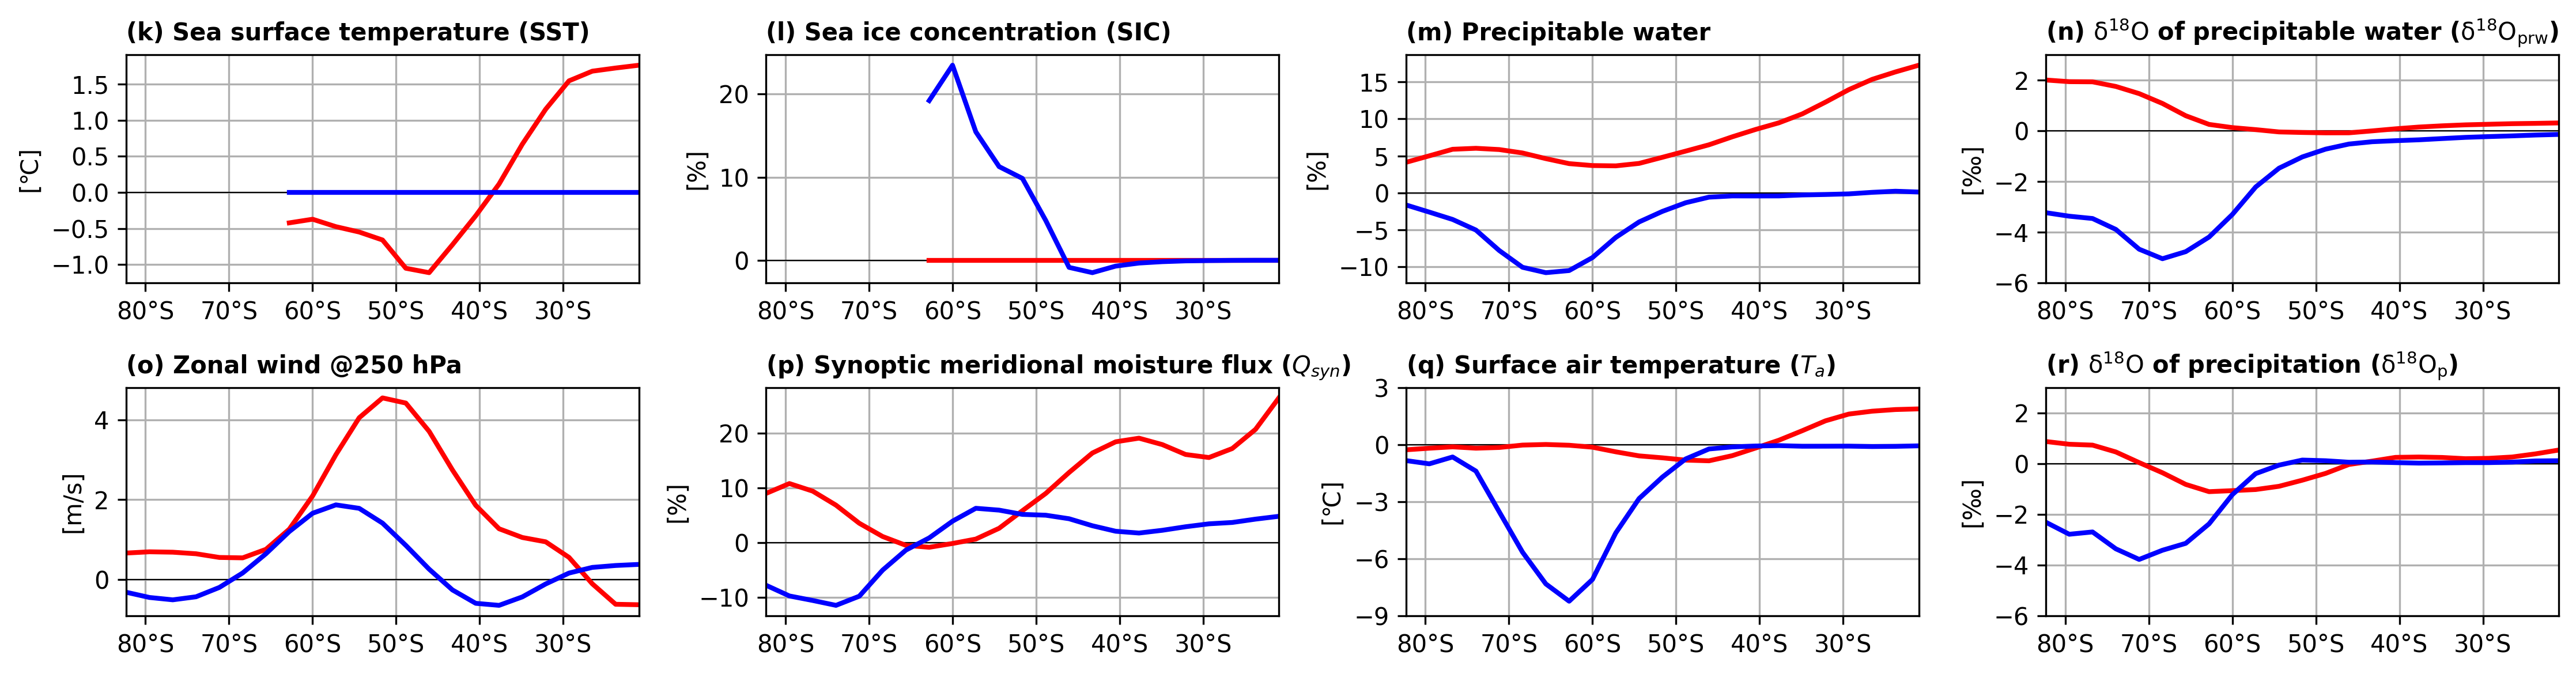

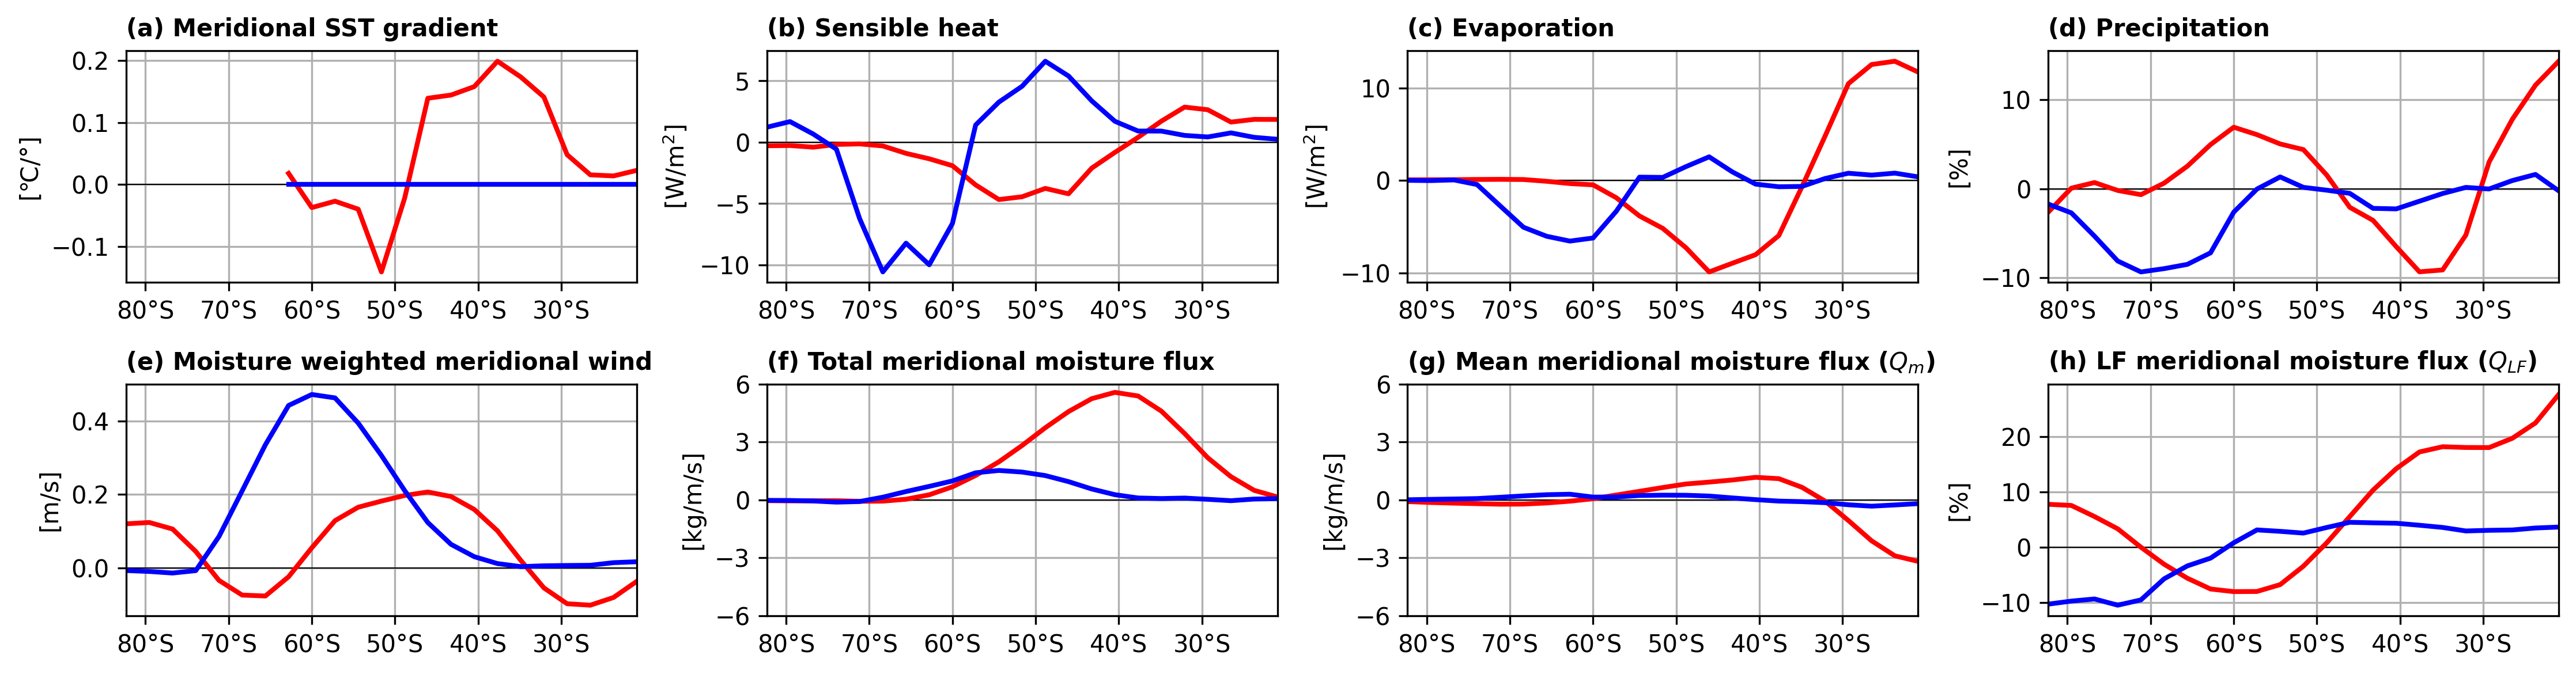

In [10]:
draw_zonalmean([ "grsst", "gricr", "precwtot", "precw_d18O", "u250","vprecw_10d_lp_residual","T2", "prcp_d18O"],sub_num=sub_num2)
draw_zonalmean(["sstgrad","sens",
     "evap","prcp",
    "vflow",
     "vprecwtot", "vprecw_1y_lp",
     "vprecw_10d_lp"])